# Find-Tuning LLMs

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 11 01:32:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   34C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--


## Install Libraries

In [ ]:
%pip install transformers datasets evaluate accelerate pipeline bitsandbytes
%pip install torch torchdata
%pip install peft
%pip install loralib
%pip install bert_score
%pip install rouge_score
%pip install huggingface_hub

In [3]:
import pandas as pd
import numpy as np
import gc
import json
import random
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from transformers import GenerationConfig, TrainingArguments, Trainer, pipeline, BitsAndBytesConfig
import torch
import evaluate
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig, prepare_model_for_kbit_training
from huggingface_hub import login

## HuggingFace Authentication


In [4]:
login()

## Config

In [11]:
# training directory
MNAME = 'dialogue'
DIR_TRAIN = f"/content/drive/MyDrive/Colab Notebooks/fine-tuning-llm/{MNAME}/peft/train/"
DIR_MODEL = f"/content/drive/MyDrive/Colab Notebooks/fine-tuning-llm/{MNAME}/peft/models/"
DIR_EVAL = f"/content/drive/MyDrive/Colab Notebooks/fine-tuning-llm/{MNAME}/"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [6]:
# Color Palettes
colors = {
    "sage"     : "#53808D",
    "orange"   : "#FC4C02",
    "blue"     : "#1B99D6",
    "yellow"   : "#FFF57B",
    "darkgrey" : "#585858",
    "lightgrey": "#D5DADD",
    "lightsage": '#E9F2EF'
}
palette_discete = sns.color_palette([v for k,v in colors.items()])
palette_continuous = sns.color_palette(f"blend:{colors['sage']},{colors['orange']}", as_cmap=True)

# custom theme
rc = {
    'axes.facecolor':f"{colors['lightsage']}",
    "axes.edgecolor":f"{colors['sage']}",
    "text.color":f"{colors['sage']}",
    "axes.labelcolor":f"{colors['sage']}",
    "ytick.color":f"{colors['sage']}",
    "xtick.color":f"{colors['sage']}",
}
sns.set_style('whitegrid',rc =rc)

# set context elements
sns.set_context('notebook',rc={'grid.linewidth':'1.1'})

# set custom palette
sns.set_palette(palette_discete)

palette_discete

[(0.3254901960784314, 0.5019607843137255, 0.5529411764705883),
 (0.9882352941176471, 0.2980392156862745, 0.00784313725490196),
 (0.10588235294117647, 0.6, 0.8392156862745098),
 (1.0, 0.9607843137254902, 0.4823529411764706),
 (0.34509803921568627, 0.34509803921568627, 0.34509803921568627),
 (0.8352941176470589, 0.8549019607843137, 0.8666666666666667),
 (0.9137254901960784, 0.9490196078431372, 0.9372549019607843)]

## Fine Tuning Dataset
+ [DialogSum](https://paperswithcode.com/dataset/dialogsum)
+ [Datasets](https://odsc.medium.com/10-datasets-for-fine-tuning-large-language-models-d27f5a9b2a9a)

In [7]:
# dialouge summary dataset
data_dialogsum = load_dataset('knkarthick/dialogsum')
data_dialogsum

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

# FlanT5

### Foundational Model

In [15]:
model_flan_name = 'google/flan-t5-base'
base_flan_model = AutoModelForSeq2SeqLM.from_pretrained(model_flan_name, torch_dtype=torch.bfloat16, device_map='auto')
tokenizer_flan = AutoTokenizer.from_pretrained(model_flan_name)

In [126]:
def prepare_dialoge_prompt(dialogue):
    """"""
    prompt = "Summarize the following conversation:\n\n"
    prompt += f"{dialogue}"
    prompt += "\n\n Summary:"
    return prompt

In [127]:
def generate_dialogue_summaries(data, model, tokenizer, indexes,verbose=True):
    """"""
    summaries=[]
    for idx in indexes:
        dialogue = data['test'][idx]['dialogue']
        human_summary = data['test'][idx]['summary']

        # tokenize the input dialogue into tokens
        tokens = tokenizer(prepare_dialoge_prompt(dialogue), return_tensors='pt')
        tokens.to(DEVICE)

        # get the model summary, decode from tokens back to text
        genai_summary = tokenizer.decode(
            model.generate(
                input_ids=tokens['input_ids'],
                max_new_tokens = 200,
            )[0],
            skip_special_tokens = True
        )

        # accumulate summaries
        summaries.append(
            {'index':idx,'human':human_summary,'genai':genai_summary}
        )

        #optional print
        if verbose:
          # print the summaries
          print(f"Dialogue:{idx}")
          print("="*100)
          print(dialogue)
          print("\nHuman Summary",'-'*88)
          print(human_summary,'\n')
          print("GenAI Summary",'-'*88)
          print(genai_summary)
          print("="*100,'\n')
    return summaries

# sample generations from the base model
summaries = generate_dialogue_summaries(
    data_dialogsum,
    base_flan_model,
    tokenizer_flan,
     [40,200],
    False
    )

summaries

[{'index': 40,
  'human': '#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.',
  'genai': 'The train is about to leave.'},
 {'index': 200,
  'human': "#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.",
  'genai': "#Person1#: You'd probably want to upgrade your computer. #Person2#: You could also upgrade your hardware. #Person1#: You'd probably want a faster processor, more memory and a faster modem. #Person2#: You might also want a CD-ROM drive."}]

### Preprocessing

In [180]:
def preprocess(example):
    """"""
    prompt_start = "Summarize the following conversation: \n\n"
    prompt_end = "\n\nSummary:"
    prompt = [prompt_start + d + prompt_end for d in example['dialogue']]
    example['input_ids'] = tokenizer_flan(prompt, padding="max_length", truncation=True, return_tensors='pt').input_ids
    example['labels'] = tokenizer_flan(example['summary'], padding="max_length",truncation=True, return_tensors='pt').input_ids

    return example

In [181]:
# preprocess the data (prepare the prompts and tokenize the inputs)
tokenized_datasets = data_dialogsum.map(preprocess, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id','dialogue','summary','topic'])
print(tokenized_datasets)

# Filter to speed up training on CPU (keep every 100th observation)
# tokenized_datasets = tokenized_datasets.filter(lambda example, index:index % 100 ==0, with_indices=True)
# print(tokenized_datasets)

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 500
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1500
    })
})


## PEFT
#### LoRA Config

In [192]:
lora_config = LoraConfig(
    r = 32,
    lora_alpha=32,
    target_modules = ["q","v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

peft_model = get_peft_model(base_flan_model, lora_config)

### Training

In [193]:
config_training = TrainingArguments(
    output_dir=DIR_TRAIN,
    auto_find_batch_size=True,
    learning_rate=1e-3,
    num_train_epochs=5,
    logging_steps=1,
    max_steps=100
)
trainer = Trainer(
    model=peft_model,
    args=config_training,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

# train
trainer.train()


# save adaptor weights
trainer.model.save_pretrained(DIR_MODEL)
tokenizer_flan.save_pretrained(DIR_MODEL)
peft_model.save_pretrained(DIR_MODEL, save_adaptor=True, save_config=True)




max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
1,48.750000
2,45.750000
3,44.250000
4,38.000000
5,34.500000
6,30.500000
7,27.750000
8,26.000000
9,24.625000
10,21.750000


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Merge Models





In [194]:
# merge base model + peft adaptors
tuned_model = PeftModel.from_pretrained(
    base_flan_model,
    DIR_MODEL,
    torch_dthype=torch.bfloat16,
    trust_remote_code=True,
    is_trainable=False
  )

# tuned_model = tuned_model.merge_and_unload()

In [195]:
generate_dialogue_summaries(
    data_dialogsum,
    tuned_model,
    tokenizer_flan,
    [40,200],
    False
  )

[{'index': 40,
  'human': '#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.',
  'genai': 'The train is about to be off.'},
 {'index': 200,
  'human': "#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.",
  'genai': 'You might also want to upgrade your hardware because it is pretty outdated now. #Person1# might need a faster processor, to begin with.'}]

### Evaluate Model Performance
+ [hugging face evaluation metrics](https://huggingface.co/evaluate-metric)
+ [Rouge Score](https://huggingface.co/spaces/evaluate-metric/rouge):
+ [BERT Score](https://huggingface.co/spaces/evaluate-metric/bertscore):

In [196]:
def evaluate_models(summaries,eval_metric = 'bert',aggregate=True):
  """"""

  # rouge Scores
  if eval_metric == 'rouge':
    rouge = evaluate.load('rouge')
    scores = rouge.compute(
      predictions = [s['genai'] for s in summaries],
      references = [s['human'] for s in summaries],
      use_aggregator=aggregate,
      use_stemmer=True,
      rouge_types = ['rougeL']
    )['rougeL']

  # BERT scores
  elif eval_metric == 'bert':
    bert = evaluate.load("bertscore")
    scores = bert.compute(
        predictions = [s['genai'] for s in summaries],
        references = [s['human'] for s in summaries],
        lang='en'
    )['f1']
    if aggregate:
      scores = np.mean(scores['f1'])
  else:
    raise Exception("eval_metric must be bert or rouge!")

  return scores

In [197]:
def plot_evaluation_boxplots(scores,metric):
    """Plot boxplots of model results for the eval-metric"""

    # convert to dataframe
    df = pd.DataFrame(scores)

    # calculate the median results
    base = df.median()['base']
    tuned=df.median()['tuned']

    # create the plot
    title = f"Evaluation Metrics: base{base:,.2f} | tuned:{tuned:,.2f}"
    plt.Figure()
    plot = sns.boxplot(data = pd.DataFrame(scores))
    plot.set(title= title, ylabel=metric)

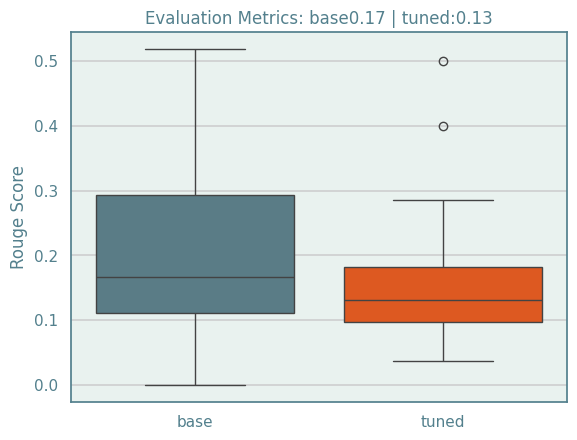

In [198]:
# reload the unadjusted base model for comparision
model_flan_name = 'google/flan-t5-base'
base_flan_model = AutoModelForSeq2SeqLM.from_pretrained(model_flan_name, torch_dtype=torch.bfloat16,device_map='auto')

# generate summaries for sample test data
num_samples = data_dialogsum['test'].num_rows-1
num_to_test = 30
test_indexes = random.sample(range(num_samples),num_to_test)

summaries_base_model = generate_dialogue_summaries(data_dialogsum, base_flan_model, tokenizer_flan, test_indexes,False)
summaries_tuned_model = generate_dialogue_summaries(data_dialogsum, tuned_model, tokenizer_flan, test_indexes,False)

# Evaluate the performace vs the human labels
# base model:
scores_base = evaluate_models(summaries_base_model,'rouge',False)

# tuned model
scores_tuned = evaluate_models(summaries_tuned_model,'rouge',False)

# save evalutions
scores = {'base':scores_base,'tuned':scores_tuned}


# Plot Results
plot_evaluation_boxplots(scores,'Rouge Score')

with open(f"{DIR_EVAL}eval_dialogue.json", "w") as outfile:
    json.dump(scores, outfile)



# Mistral 7b
+ https://exnrt.com/blog/ai/mistral-7b-fine-tuning/#google_vignette

In [82]:
# summarization dataset
data_xsum = load_dataset("xsum")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1491: FutureWarning: The repository for xsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xsum
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

In [83]:
base_mistral_model_name = 'mistralai/Mistral-7B-v0.1'
quant_config = BitsAndBytesConfig(load_in_4bit=True)

base_mistral_model = AutoModelForCausalLM.from_pretrained(
    base_mistral_model_name,
    device_map='auto',
    use_cache=False,
    torch_dtype =torch.bfloat16,
    quantization_config=quant_config
    )
tokenizer_mistral = AutoTokenizer.from_pretrained(base_mistral_model_name)

tokenizer_mistral.pad_token = tokenizer_mistral.eos_token
tokenizer_mistral.padding_side = 'right'

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [200]:
max_input_length = 1024
max_target_length = 128

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


{'input_ids': [[1, 6312, 28709, 28808], [1, 910, 460, 368, 28804]], 'attention_mask': [[1, 1, 1, 1], [1, 1, 1, 1, 1]]}

In [123]:
def create_summary_prompt(doc):

  prompt = '<s>[INST]Summarize the following document in three or fewer sentences:[/INST]\n'
  prompt += doc
  prompt += '</s>'
  prompt += '\n### Response:'
  return prompt


In [113]:
def create_instruciton_summarization_prompt(example):
    """"""
    bos_token ="<s>"
    eos_token = "</s>"
    system = 'Your task is to sumarizse the following document in two or fewer sentences. For instance, the following document:\n'
    doc = example['document']
    response = example['summary']

    prompt = ""
    prompt += bos_token
    prompt += '[INST]\n'
    prompt += system
    prompt += doc
    prompt += '\nWould be summarized as follows:'
    prompt += '[/INST]\n'
    prompt += response
    prompt += eos_token

    return prompt


# print(create_instruciton_summarization_prompt(data_xsum['test'][0]))

In [124]:
def get_summary_response(prompt, model):
  encoded_input = tokenizer_mistral(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encoded_input.to(DEVICE)

  generated_ids = model.generate(**model_inputs, max_new_tokens=1000, do_sample=True,pad_token_id=tokenizer_mistral.eos_token_id)

  decoded_output = tokenizer_mistral.batch_decode(generated_ids)

  return decoded_output[0].replace(prompt, "")


In [190]:
def generate_summaries(data, model, tokenizer, indexes,verbose=True):
    """"""
    summaries=[]
    for idx in indexes:
        doc = data['test'][idx]['document']
        human_summary = data['test'][idx]['summary']
        prompt = create_summary_prompt(doc)

        # generate the response
        genai_summary = get_summary_response(prompt,model)

        # accumulate summaries
        summaries.append(
            {'index':idx,'human':human_summary,'genai':genai_summary}
        )

        #optional print
        if verbose:
          # print the summaries
          print(f"Dialogue:{idx}")
          print("="*100)
          print(doc)
          print("\nHuman Summary",'-'*88)
          print(human_summary,'\n')
          print("GenAI Summary",'-'*88)
          print(genai_summary)
          print("="*100,'\n')
    return summaries

generate_summaries(data_xsum, base_mistral_model, tokenizer_mistral, [200],False)

[{'index': 200,
  'human': 'Harry Potter spin-off Fantastic Beasts and Where To Find Them has had the biggest UK box office opening weekend of the year so far.',
  'genai': '<s><s> [INST]Summarize the following document in three or fewer sentences:[/INST]\nThe film, written by JK Rowling and starring Eddie Redmayne as Newt Scamander, took a total of £15.3m.\nIt is the third highest opening weekend from the JK Rowling series, behind the two final Harry Potter films.\nWarner Bros executive Josh Berger said: "We are thrilled with the huge response from British and Irish audiences."\nThe film also worked its magic at North American cinemas, taking an estimated $75m (£61m) over the weekend - more than the rest of the US box office top 10 combined.\nHarry Potter creator Rowling has planned scripts for a total of five films in the series.\nThe first instalment is set in New York, and tells the story of a fictional author mentioned in the Potter stories.\nRedmayne plays the part of the animal-

In [ ]:
# generator = pipeline(
#     "text-generation",
#     model=base_model,
#     tokenizer = tokenizer,
#     torch_dtype=torch.bfloat16,
#     device_map="auto"
# )

# prompt = "As a data scientist, can you explain the concept of regularization in machine learning?"
# generator(prompt,
#           pad_token_id=generator.tokenizer.eos_token_id,
#           max_new_tokens=100
#           )



# sequences = pipe(
#     prompt,
#     do_sample=True,
#     max_new_tokens=100,
#     temperature=0.7,
#     top_k=50,
#     top_p=0.95,
#     num_return_sequences=1,
# )
# print(sequences[0]['generated_text'])

In [ ]:
# process_prompt()

In [15]:
# prompt = "My favourite condiment is"
# model_inputs = tokenizer([prompt], return_tensors="pt")
# model_inputs

#


{'input_ids': tensor([[    1,  1984, 16020,  2076,  2487,   349]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}